In [1]:
import pandas as pd

# Load the CSV file
df = pd.read_csv("../data/data.csv")

In [2]:
# Display basic info
print("Dataset shape:", df.shape)
df.info(verbose=True)

Dataset shape: (159571, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [3]:
df["toxic"] = df.iloc[:, 2:8].sum(axis=1) > 0
df.drop(df.columns[3:8], axis=1, inplace=True)

In [4]:
df.head(10)

,id,comment_text,toxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,False
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,False
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",False
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",False
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",False
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",False
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,True
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,False
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,False
9,00040093b2687caa,alignment on this subject and which are contra...,False


In [5]:
import re

def clean_text(text):
    text = text.lower()                              # 1. Lowercase
    text = re.sub(r'[^a-z\s]', '', text)             # 2. Keep only letters and spaces
    text = re.sub(r'\s+', ' ', text).strip()         # 3. Remove extra spaces
    return text
df['comment_text'] = df['comment_text'].apply(clean_text)
df = df[df['comment_text'].str.strip() != '']

In [6]:
def split_long_comments(df, max_len=1000, min_len_if_toxic=30):
    new_rows = []

    for idx, row in df.iterrows():
        text = row['comment_text']
        label = row['toxic']  # True or False

        if len(text) <= max_len:
            new_rows.append({'comment_text': text, 'toxic': label})
        else:
            for i in range(0, len(text), max_len):
                chunk = text[i:i + max_len]

                # ✅ Skip tiny chunks *only* if the original comment was toxic
                if label and len(chunk) < min_len_if_toxic:
                    continue

                new_rows.append({'comment_text': chunk, 'toxic': label})

    return pd.DataFrame(new_rows)

In [7]:
long_comments = df['comment_text'].apply(len) > 1000
count = long_comments.sum()
print("Number of comments longer than 1000 characters:", count)
df = split_long_comments(df)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

Number of comments longer than 1000 characters: 12141


In [8]:
df.shape

(177960, 2)

In [9]:
df.head(10)

,comment_text,toxic
0,this list serves no purpose other than to prov...,False
1,stalin could never have been impersonated thro...,False
2,usernawlinwiki is gay that person is gay they ...,True
3,fredomopenneslicenses is it free software what...,False
4,reverting for no reason i spent quite some tim...,True
5,image jpg listed for deletion an image or medi...,False
6,well the events of february invalidate your st...,False
7,sorry you are way wrong on this one here is th...,False
8,fanfictionnets policy change and the effect of...,False
9,citation templates trying to add citation temp...,False


In [10]:
df.isnull().sum()

comment_text    0
toxic           0
dtype: int64

In [11]:
toxic_counts = df["toxic"].value_counts()
print("Toxic: ", round(toxic_counts[True]/df.shape[0]*100, 2), "%")

Toxic:  9.93 %


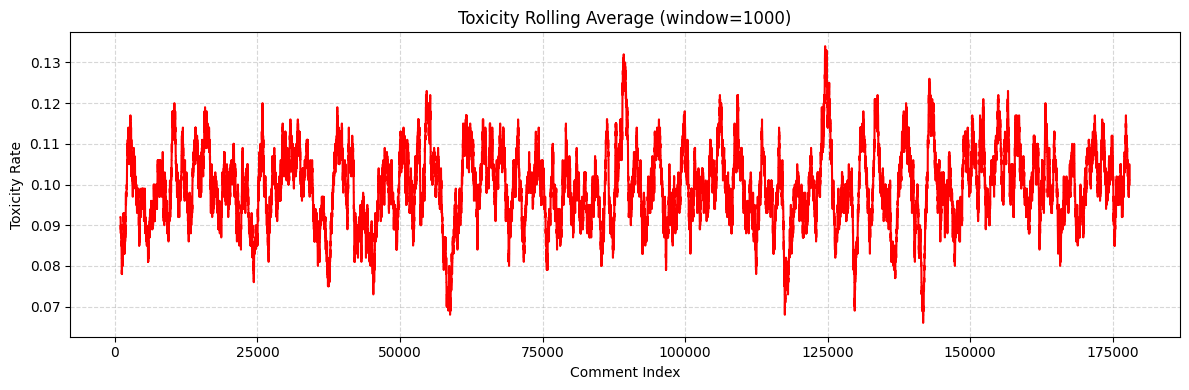

In [12]:
import matplotlib.pyplot as plt

# Compute rolling average
window_size = 1000  # try 500 or 1000
rolling_avg = df["toxic"].rolling(window=window_size).mean()

# Plot
plt.figure(figsize=(12, 4))
plt.plot(rolling_avg, color='red')
plt.title(f"Toxicity Rolling Average (window={window_size})")
plt.xlabel("Comment Index")
plt.ylabel("Toxicity Rate")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [13]:
# Get indices of toxic comments
toxic_indices = df.index[df["toxic"]==1].to_list()

# Calculate distances between toxic comments
gaps = [j - i for i, j in zip(toxic_indices[:-1], toxic_indices[1:])]

# Analyze gaps
import numpy as np
print("Average gap between toxic comments:", np.mean(gaps))
print("Min gap:", np.min(gaps))
print("Max gap:", np.max(gaps))

Average gap between toxic comments: 10.066542182991004
Min gap: 1
Max gap: 99


In [14]:
print("Duplicate comments:", df.duplicated("comment_text").sum())

Duplicate comments: 1974


In [15]:
df = df.drop_duplicates(subset=["comment_text", "toxic"]).reset_index(drop=True)
print("Duplicate comments:", df.duplicated("comment_text").sum())

Duplicate comments: 42


In [16]:
df.head(5)

,comment_text,toxic
0,this list serves no purpose other than to prov...,False
1,stalin could never have been impersonated thro...,False
2,usernawlinwiki is gay that person is gay they ...,True
3,fredomopenneslicenses is it free software what...,False
4,reverting for no reason i spent quite some tim...,True


In [17]:
from sklearn.model_selection import train_test_split

# Step 1: train + temp (val + test)
train_df, temp_df = train_test_split(
    df, 
    test_size=0.3, 
    stratify=df['toxic'], 
    random_state=42
)

# Step 2: val + test from temp
val_df, test_df = train_test_split(
    temp_df, 
    test_size=0.5, 
    stratify=temp_df['toxic'], 
    random_state=42
)


In [18]:
print(train_df["toxic"].value_counts())
print(val_df["toxic"].value_counts())
print(test_df["toxic"].value_counts())

toxic
False    111050
True      12169
Name: count, dtype: int64
toxic
False    23796
True      2608
Name: count, dtype: int64
toxic
False    23797
True      2608
Name: count, dtype: int64


In [19]:
train_df.to_csv("../data/train.csv", index=False)
val_df.to_csv("../data/val.csv", index=False)
test_df.to_csv("../data/test.csv", index=False)